In [1]:
import random
import itertools
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.optimize import minimize, LinearConstraint
import seaborn as sns
import matplotlib.pyplot as plt
import pprint

mp = pprint.PrettyPrinter(indent=2).pprint

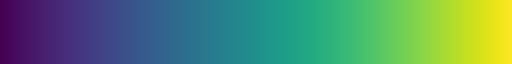

In [2]:
# Colour pallette
sns.color_palette("viridis", as_cmap=True)

In [3]:
stances = ["True", "False", "Unsure", "Vague", "Unanswered"]


class JointDistribution:
    def __init__(self, data=None, baseline=1):
        if data == None:
            data = [
                (a, b, baseline + random.randint(0, 100))
                for a, b in itertools.product(stances, repeat=2)
            ]
        self.votes = pd.DataFrame(
            data=data,
            columns=["statement_a", "statement_b", "votes"],
        )
        self.entropies = {
            "a": entropy(
                list(self.votes.groupby("statement_a").sum()["votes"]), base=2
            ),
            "b": entropy(
                list(self.votes.groupby("statement_b").sum()["votes"]), base=2
            ),
            "total": entropy(self.votes["votes"], base=2),
        }

    def plot(self):
        plt.figure(figsize=(2, 2))
        g = sns.heatmap(
            data=self.votes.pivot(
                index="statement_a", columns="statement_b", values="votes"
            ),
            cmap="viridis",
        )

    def print_information_summary(self):
        mutual_information = {
            "mutual": self.entropies["a"]
            + self.entropies["b"]
            - self.entropies["total"]
        }
        mp(self.entropies | mutual_information)

    @staticmethod
    def from_flat_array(flat_array):
        return JointDistribution(
            data=[
                (a, b, v)
                for (a, b), v in zip(itertools.product(stances, repeat=2), flat_array)
            ]
        )

In [4]:
import math

math.log(5, 2)

2.321928094887362

{ 'a': 2.3219280948873626,
  'b': 2.3219280948873626,
  'mutual': 2.321925933437947,
  'total': 2.321930256336778}


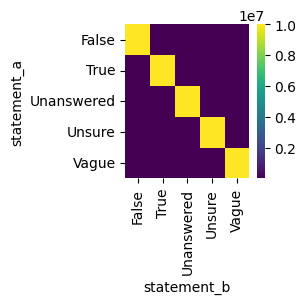

In [5]:
baseline = 0.2
jd = JointDistribution(
    data=[
        (a, b, 10**7 if a == b else baseline)
        for a, b in itertools.product(stances, repeat=2)
    ]
)
jd.print_information_summary()
jd.plot()

In [6]:
jd.votes.pivot(index="statement_a", columns="statement_b", values="votes")

statement_b,False,True,Unanswered,Unsure,Vague
statement_a,,,,,
False,10000000.0,0.2,0.2,0.2,0.2
True,0.2,10000000.0,0.2,0.2,0.2
Unanswered,0.2,0.2,10000000.0,0.2,0.2
Unsure,0.2,0.2,0.2,10000000.0,0.2
Vague,0.2,0.2,0.2,0.2,10000000.0


In [7]:
def loss_function(vector: np.ndarray) -> float:
    jd = JointDistribution.from_flat_array(vector)
    return np.divide(
        jd.entropies["total"] - jd.entropies["b"],
        jd.entropies["total"] - jd.entropies["a"],
    )

{ 'a': 0.3265606178997153,
  'b': 2.319772731496179,
  'mutual': 9.269600793304633e-05,
  'total': 2.646240653387961}


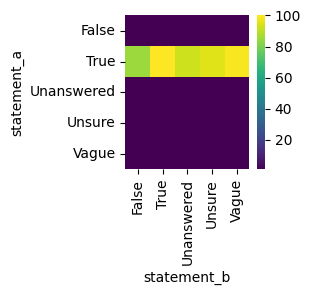

In [8]:
x = minimize(
    x0=[random.randint(1, 5) for _ in range(25)],
    # x0=x.x,
    fun=loss_function,
    method="SLSQP",
    constraints={
        LinearConstraint(
            A=np.diag(np.ones(25)), ub=np.divide(np.ones(25), 0.01), lb=np.ones(25)
        )
    },
)
minimal_jd = JointDistribution.from_flat_array(x.x)
minimal_jd.print_information_summary()
minimal_jd.plot()